# EDA of dpi dataset (application usage data)

Examine data from `dpi` dataset and decide what extra features can we get.

## TLDR

- pick top applications, group by `abon_id` to get single row per subscriber
- add some aggregations based on feature interaction
- train baseline model. Accuracy: `0.6135` / `0.5039`, 2888 features
- perform feature selection using permutation importance
- train model with reduced feature set:
  - top 200 features accuracy: `0.6456` / `0.4989`, 93.07% features dropped


In [1]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from utils import eda
from utils import io
import utils.model_lgb as model_lgb
import project.project_api as project_api
import project.dpi as dpi
import plotly.express as px
import seaborn as sns

In [2]:
RANDOM_SEED = 42
TARGET_KEY = "target"
CLASS_NUM = 5

Dictionary:

- `abon_id` — subscriber id
- `Application` — application id
- `MAX_of_day_cnt` — days count of application usage
- `SUM_of_Duration_sec` — session duration inside app
- `SUM_of_Count_events` — sessions count in app
- `SUM_of_Volume_kb` — in/out application traffic


In [3]:
df_train_targets = pd.read_parquet(
    "./data/train_fe/",
    columns=[TARGET_KEY],
)

In [4]:
df_train_dpi = pd.read_parquet("./data/train_dpi")
df_train_dpi = df_train_dpi.merge(
    df_train_targets,
    how="left",
    left_index=True,
    right_index=True,
)

print(df_train_dpi.info())
df_train_dpi

<class 'pandas.core.frame.DataFrame'>
Index: 7058446 entries, 1525928 to 131296645
Data columns (total 6 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Application          int16  
 1   SUM_of_Duration_sec  float16
 2   SUM_of_Volume_kb     float16
 3   SUM_of_Count_events  float16
 4   MAX_of_day_cnt       float16
 5   target               int8   
dtypes: float16(4), int16(1), int8(1)
memory usage: 101.0 MB
None


,Application,SUM_of_Duration_sec,SUM_of_Volume_kb,SUM_of_Count_events,MAX_of_day_cnt,target
abon_id,,,,,,
1525928,115,45.375000,109.500000,27.015625,3.0,4
1525928,175,41.125000,54.187500,14.421875,5.0,4
1525928,240,103.750000,144.125000,59.968750,16.0,4
1525928,246,18.296875,1.418945,1.480469,1.0,4
1525928,254,57.656250,74.750000,28.531250,19.0,4
...,...,...,...,...,...,...
131296645,1127,15.984375,5.457031,1.480469,1.0,2
131296645,1353,1.480469,5.886719,1.480469,1.0,2
131296645,1373,25.484375,21.109375,4.785156,2.0,2


<div class="alert alert-block alert-info">
We should pay attention that we have no apps data for some of the subscribers and therefore we won't be able to make predictions for such subscribers.
</div>


In [5]:
df_abons_without_dpi = df_train_targets.index.difference(df_train_dpi.index)

print(
    f"Subscribers without dpi data: {len(df_abons_without_dpi)} ({len(df_abons_without_dpi)/len(df_train_targets)*100:.2f}%)"
)

Subscribers without dpi data: 27154 (18.48%)


In [6]:
# expose index as column
df_train_dpi["abon_id"] = df_train_dpi.index
df_train_dpi = df_train_dpi.reset_index(drop=True)

In [7]:
eda.print_missing(df_train_dpi)

No columns with inf found!
Missing values report:
No missing values found!


,Total,Rate


In [8]:
eda.print_uniq(df_train_dpi)

Unique values report:
                       uniq          rate
target                    5  7.083712e-07
MAX_of_day_cnt           30  4.250227e-06
Application             751  1.063974e-04
SUM_of_Count_events    2843  4.027799e-04
SUM_of_Duration_sec    3378  4.785756e-04
SUM_of_Volume_kb       6877  9.742938e-04
abon_id              119799  1.697243e-02
Total rows: 7058446


## Derive additional features from available data


Group dataset by `abon_id` and aggregate some additional features. We will introduce some more feature when we will process data on application level.


In [9]:
df_dpi_extra_fe = dpi.collect_extra_fe(df_train_dpi)
df_dpi_extra_fe

No columns with inf found!
Missing values report:
No missing values found!
Mem. usage decreased to  4.57 Mb (63.0% reduction)


,total_MAX_of_day_cnt,total_SUM_of_Count_events,total_SUM_of_Duration_sec,total_SUM_of_Volume_kb,total_apps,avg_daily_session_sec_sum,avg_daily_session_cnt,avg_daily_traffic_kb,avg_session_sec,avg_session_traffic_kb,avg_session_bandwidth_kbs,avg_days_per_app,avg_session_sec_sum_per_app,avg_session_cnt_per_app,avg_traffic_kb_per_app,avg_daily_session_sec_per_app,avg_daily_session_cnt_per_app,avg_daily_traffic_kb_per_app
abon_id,,,,,,,,,,,,,,,,,,
1525928,914.0,1699.000,2904.0,3810.0000,64,3.177734,1.859375,4.167969,1.708984,2.242188,1.312500,14.281250,45.37500,26.546875,59.531250,0.049652,0.029053,0.065125
1530471,189.0,638.000,1425.0,1246.0000,45,7.539062,3.375000,6.593750,2.234375,1.953125,0.874512,4.199219,31.65625,14.171875,27.687500,0.167480,0.075012,0.146484
1541528,1622.0,3446.000,6432.0,8108.0000,106,3.964844,2.125000,5.000000,1.867188,2.353516,1.260742,15.304688,60.68750,32.500000,76.500000,0.037415,0.020035,0.047150
1545231,39.0,50.625,138.5,19.6875,8,3.550781,1.297852,0.504883,2.734375,0.388916,0.142212,4.875000,17.31250,6.328125,2.460938,0.443848,0.162231,0.063110
1553098,1170.0,2276.000,3940.0,5784.0000,75,3.369141,1.945312,4.941406,1.731445,2.541016,1.466797,15.601562,52.53125,30.343750,77.125000,0.044922,0.025940,0.065918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131293833,461.0,3060.000,5560.0,7592.0000,96,12.062500,6.640625,16.468750,1.816406,2.480469,1.365234,4.800781,57.90625,31.875000,79.062500,0.125610,0.069153,0.171509
131293849,588.0,4000.000,7324.0,9800.0000,113,12.453125,6.804688,16.671875,1.830078,2.451172,1.338867,5.203125,64.81250,35.406250,86.750000,0.110229,0.060211,0.147583
131295221,245.0,1431.000,3122.0,4300.0000,68,12.742188,5.839844,17.546875,2.181641,3.005859,1.377930,3.603516,45.90625,21.046875,63.250000,0.187378,0.085876,0.258057


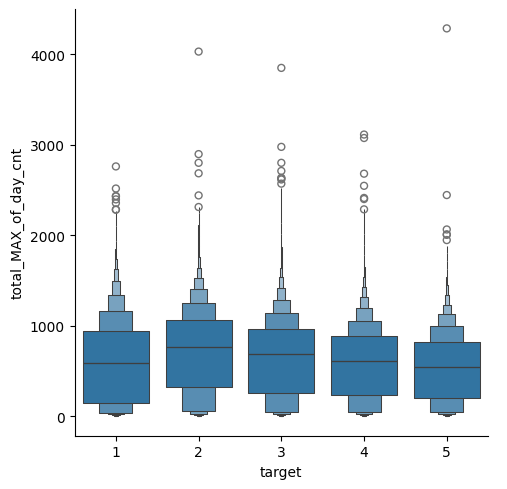

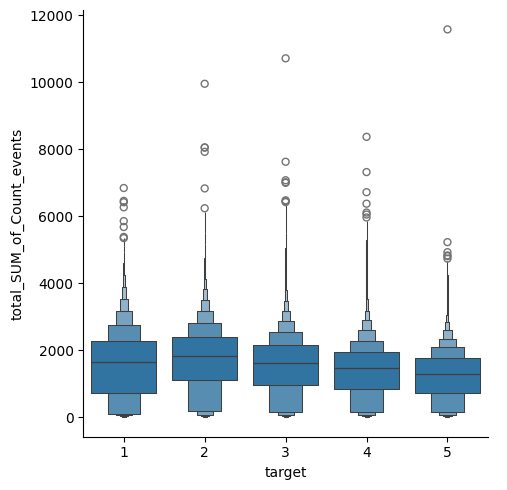

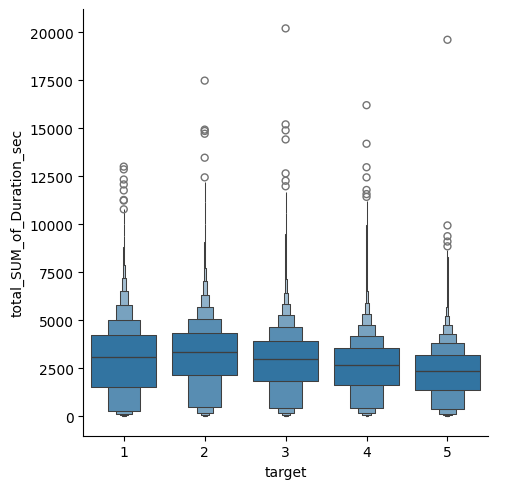

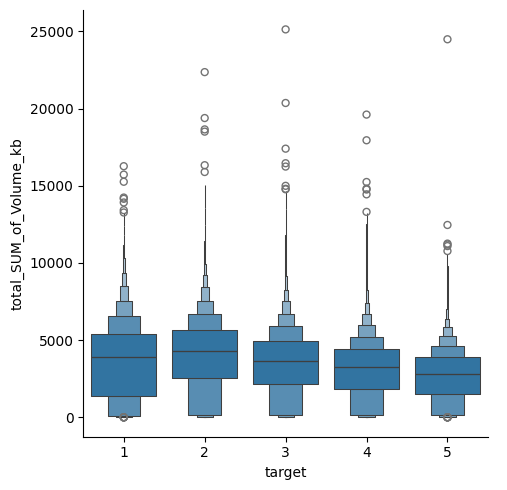

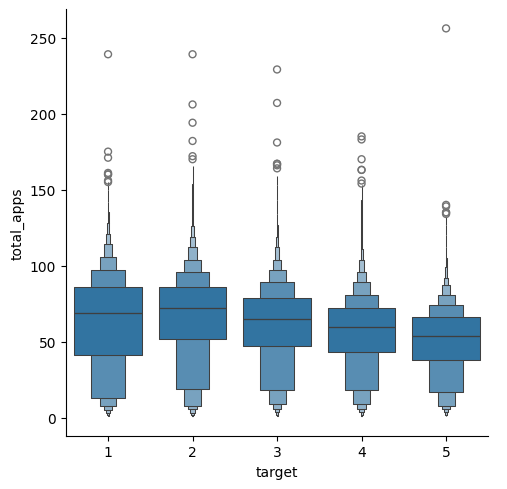

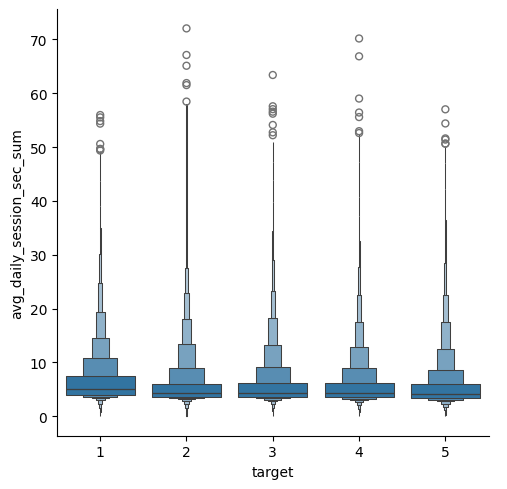

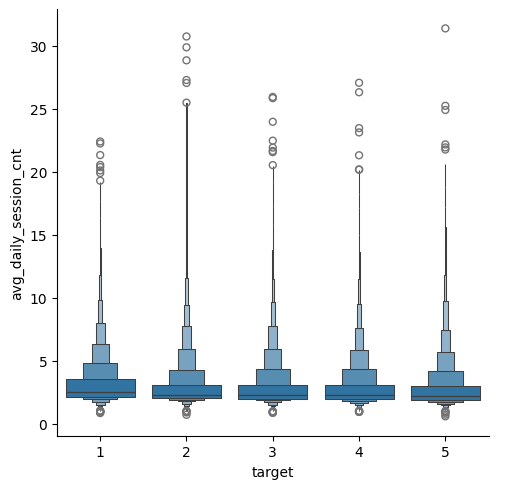

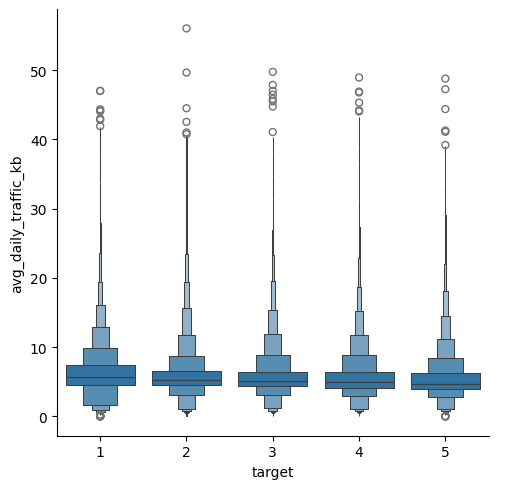

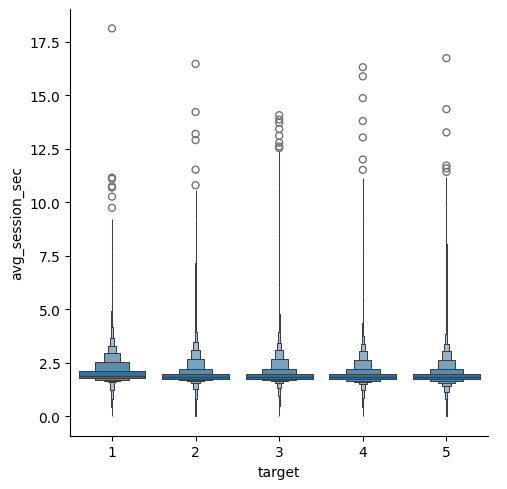

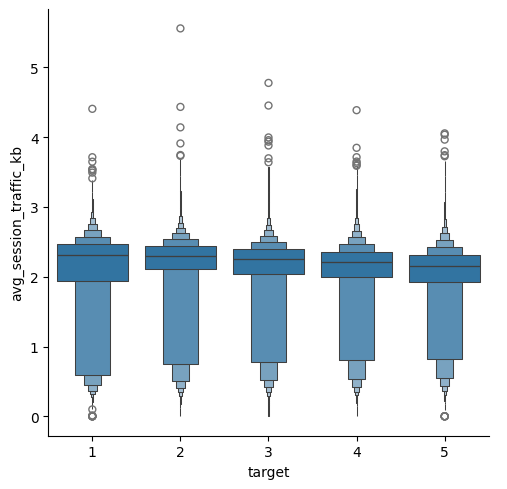

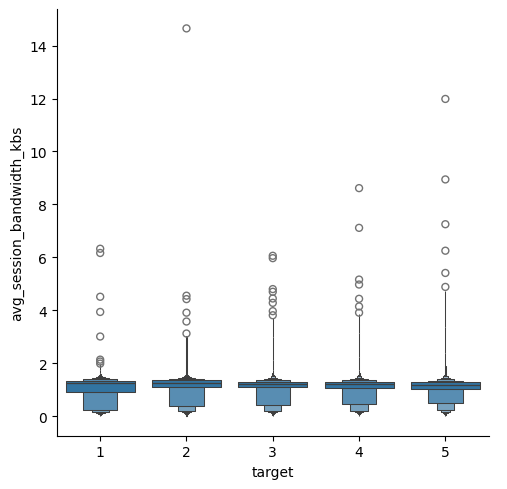

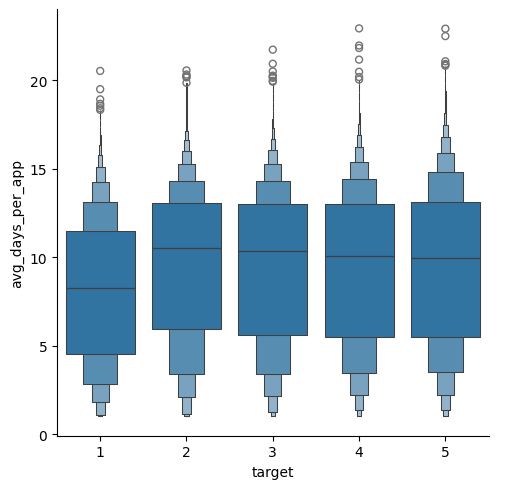

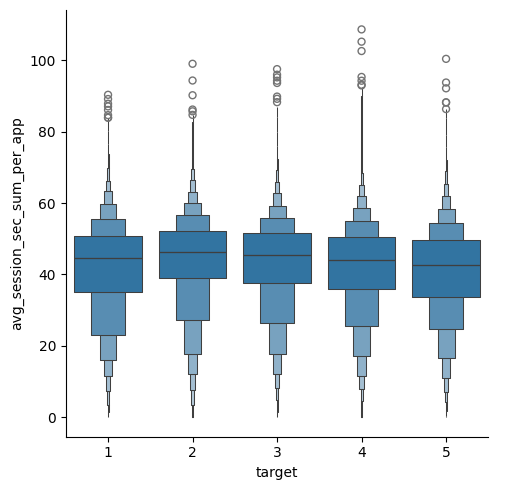

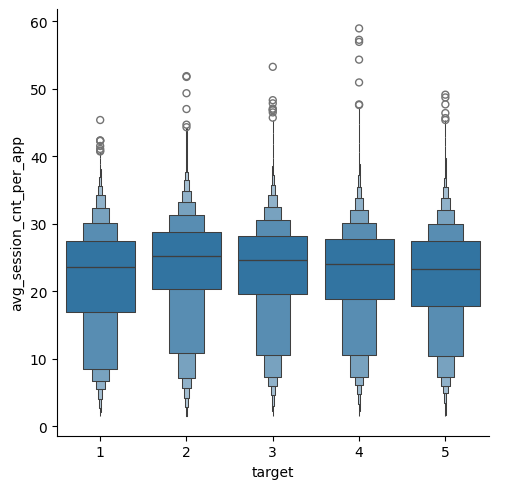

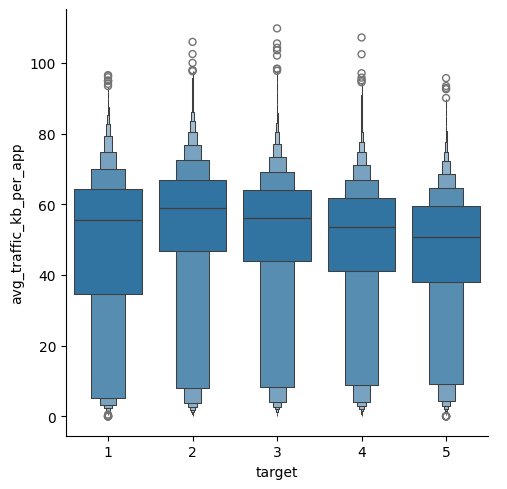

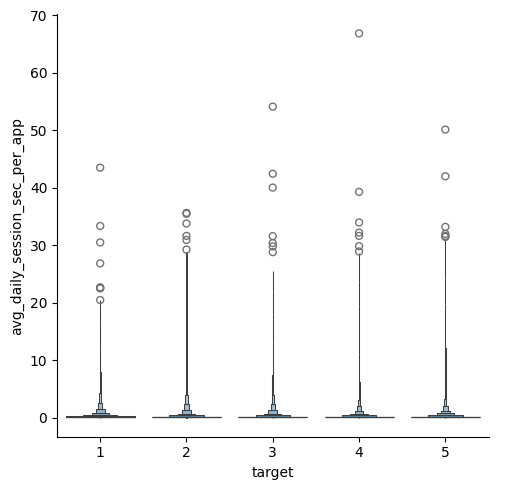

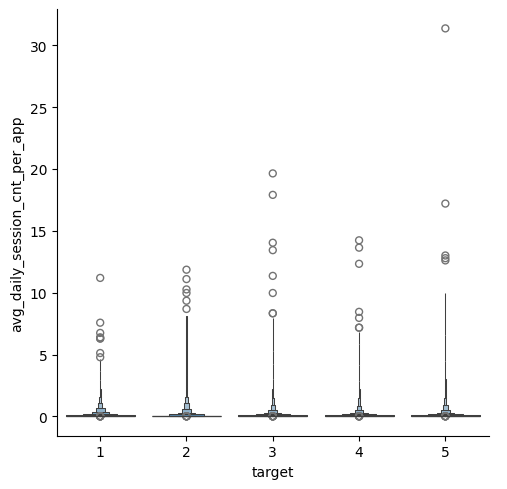

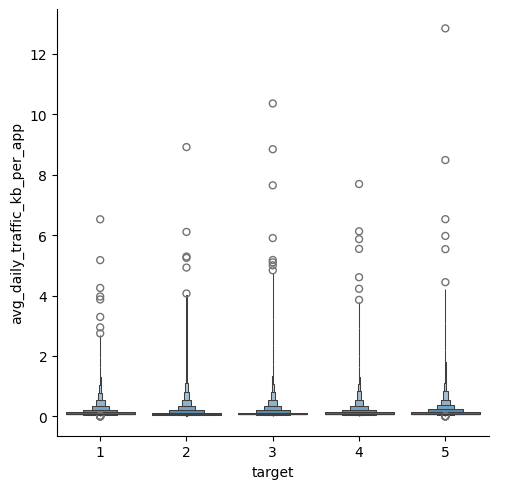

In [10]:
def visualize_abon_stats():
    df = df_dpi_extra_fe.merge(
        df_train_targets,
        how="left",
        left_index=True,
        right_index=True,
    )

    # drop subscribers without activity
    df = df[(df["total_apps"] > 0) & (df["total_SUM_of_Count_events"] > 0)]

    for key in df.drop(columns=[TARGET_KEY]).columns:
        sns.catplot(data=df, x=TARGET_KEY, y=key, kind="boxen")


visualize_abon_stats()

Some features are looking promising. Especially first vs second/last category.


<Axes: xlabel='app_id', ylabel='target'>

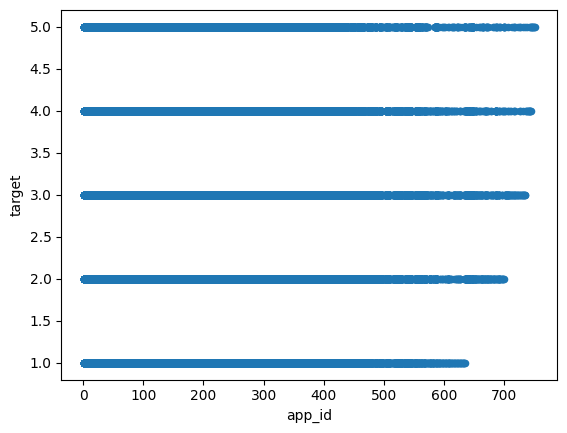

In [11]:
df_sorted = df_train_dpi.sort_values(by=[TARGET_KEY])
id_map = {}


def index_app(app):
    if not (app in id_map):
        id_map[app] = len(id_map) + 1

    return id_map[app]


df_sorted["app_id"] = df_sorted["Application"].apply(index_app)

df_sorted.plot.scatter(x="app_id", y=TARGET_KEY)

## Clean up dataset

We have 751 apps in dataset. Lets examine whether we can reduce the amount of apps to take care of.


Let's look the distribution of applications across subscribers and particular target groups. The hypothesis is that there should be some apps that are more common for some group of subscribers while is not common for the other. Therefore we don't want to examine apps that are used only by several subscribers and apps that are used by majority of subscribers.


In [12]:
bins = [
    0,
    2,
    5,
    10,
    15,
    20,
    30,
    50,
    100,
    500,
    1_000,
    2_000,
    5_000,
    10_000,
    20_000,
    30_000,
    100_000,
    120_000,
]

count, division = np.histogram(
    df_train_dpi.groupby("Application")["abon_id"]
    .count()
    .reset_index(name="count")["count"],
    bins=bins,
)

pd.DataFrame(
    {
        "abon_per_app": division[1:],
        "app_count": count,
    }
)

,abon_per_app,app_count
0,2,54
1,5,74
2,10,59
3,15,29
4,20,23
5,30,37
6,50,43
7,100,42
8,500,103
9,1000,43


In [13]:
mean_target_counts_per_app = (
    df_train_dpi.groupby(["Application", TARGET_KEY])[TARGET_KEY]
    .count()
    .reset_index(name="count")[["Application", "count"]]
    .groupby("Application")["count"]
    .mean()
    .reset_index()
)
count, division = np.histogram(
    mean_target_counts_per_app["count"],
    bins=bins,
)

pd.DataFrame(
    {
        "abon_per_target_per_app": division[1:],
        "app_count": count,
    }
)

,abon_per_target_per_app,app_count
0,2,148
1,5,107
2,10,61
3,15,25
4,20,20
5,30,21
6,50,30
7,100,52
8,500,95
9,1000,30


<Axes: title={'center': 'Mean subscriber count per app per category'}>

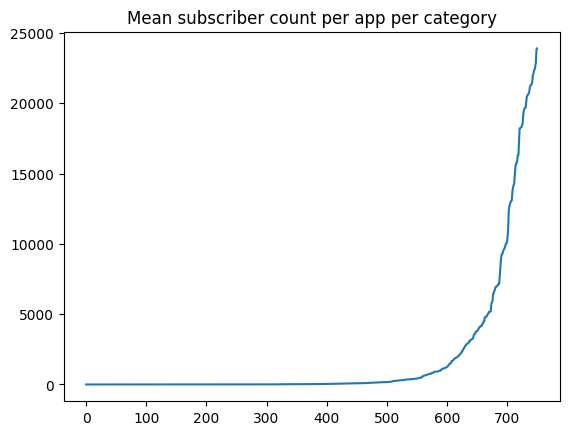

In [14]:
ax = (
    mean_target_counts_per_app["count"]
    .sort_values(ascending=True)
    .reset_index(drop=True)
    .plot.line()
)

ax.set_title("Mean subscriber count per app per category")

ax

All aps are obfuscated therefore we can not examine the tail with most used apps to drop the irrelevant. We only can cut the head of list where we have apps with small usages count. Lets drop apps with less than 15 users per category.


In [15]:
rows_before = len(df_train_dpi)
apps_before = df_train_dpi["Application"].nunique()
print(f"Rows before: {rows_before}. Apps: {apps_before}")
df_train_dpi = df_train_dpi[
    df_train_dpi["Application"].isin(
        mean_target_counts_per_app[mean_target_counts_per_app["count"] >= 15][
            "Application"
        ]
    )
]
apps_after = df_train_dpi["Application"].nunique()
print(
    f"Rows after: {len(df_train_dpi)}. Rows dropped: {rows_before - len(df_train_dpi)} ({(rows_before - len(df_train_dpi)) / rows_before * 100:.2f}%)"
)
print(
    f"Apps after: {apps_after}. Apps dropped: {apps_before - apps_after} ({(apps_before - apps_after) / apps_before * 100:.2f}%)"
)

Rows before: 7058446. Apps: 751
Rows after: 7053205. Rows dropped: 5241 (0.07%)
Apps after: 410. Apps dropped: 341 (45.41%)


In [16]:
mean_target_counts_per_app = (
    df_train_dpi.groupby(["Application", TARGET_KEY])[TARGET_KEY]
    .count()
    .reset_index(name="count")[["Application", "count"]]
    .groupby("Application")["count"]
    .mean()
    .reset_index()
)
count, division = np.histogram(
    mean_target_counts_per_app["count"],
    bins=bins,
)

pd.DataFrame(
    {
        "abon_per_target_per_app": division[1:],
        "app_count": count,
    }
)

,abon_per_target_per_app,app_count
0,2,0
1,5,0
2,10,0
3,15,0
4,20,20
5,30,21
6,50,30
7,100,52
8,500,95
9,1000,30


In [17]:
def plot_filtered():
    abon_by_app = df_train_dpi.groupby("Application")["abon_id"].count()

    df_sorted = (
        df_train_dpi.groupby(["Application", TARGET_KEY])[TARGET_KEY]
        .count()
        .reset_index(name="count")
    )
    df_sorted["apps_percent"] = df_sorted.apply(
        lambda series: series["count"] / abon_by_app[series["Application"]],
        axis=1,
    )

    df_sorted = df_sorted.sort_values(by=[TARGET_KEY, "count"])
    id_map = {}

    def index_app(app):
        if not (app in id_map):
            id_map[app] = len(id_map) + 1

        return id_map[app]

    df_sorted["app_id"] = df_sorted["Application"].apply(index_app)
    df_sorted["abon_count_bin"] = df_sorted["count"].apply(
        # find the bin value
        lambda count: str(next(x for x in bins if count < x))
    )

    return px.scatter(
        df_sorted,
        x="app_id",
        y=TARGET_KEY,
        color="abon_count_bin",
        hover_name="count",
        title=f"Aggregated app counts per target. App count: {df_sorted['Application'].nunique()}",
        size="apps_percent",
        # size_max=50,
    )


plot_filtered()

## Prepare datasets for training


Persist list of apps that we are planning to work with:


In [18]:
dpi_selection_path = "./data/dpi_initial_names.json"
all_dpi = list(df_train_dpi["Application"].unique().tolist())


io.write_json(dpi_selection_path, all_dpi)

During preprocess stage we will add previousely derived features and will compute some more to get app importance per subscriber (e.g. which usage rate of particular app among other user's apps).


In [19]:
X_train, y_train = dpi.preprocess(
    name="dpi_initial_train",
    dpi_path="./data/train_dpi",
    fe_path="./data/train_fe",
    dpi_selection_path=dpi_selection_path,
)
print(f"Train X: {X_train.shape}")
print(f"Train y: {y_train.shape}")

X_test, y_test = dpi.preprocess(
    name="dpi_initial_test",
    dpi_path="./data/test_dpi",
    fe_path="./data/test_fe",
    dpi_selection_path=dpi_selection_path,
)
print(f"Test X: {X_test.shape}")
print(f"Test y: {y_test.shape}")

X_train

Train X: (119798, 2888)
Train y: (119798, 1)
Test X: (36050, 2888)
Test y: (36050, 1)


,MAX_of_day_cnt_115,SUM_of_Duration_sec_115,SUM_of_Count_events_115,SUM_of_Volume_kb_115,daily_session_dur_rate_115,daily_session_cnt_rate_115,daily_traffic_rate_115,MAX_of_day_cnt_175,SUM_of_Duration_sec_175,SUM_of_Count_events_175,...,avg_session_sec,avg_session_traffic_kb,avg_session_bandwidth_kbs,avg_days_per_app,avg_session_sec_sum_per_app,avg_session_cnt_per_app,avg_traffic_kb_per_app,avg_daily_session_sec_per_app,avg_daily_session_cnt_per_app,avg_daily_traffic_kb_per_app
abon_id,,,,,,,,,,,,,,,,,,,,,
1525928,3.0,45.3750,27.015625,109.500000,0.047791,0.061371,0.073059,5.0,41.125000,14.421875,...,1.708984,2.242188,1.312065,14.281250,45.37500,26.546875,59.531250,0.049652,0.029053,0.065125
1530471,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,7.964844,2.207031,...,2.234375,1.953125,0.874587,4.199219,31.65625,14.171875,27.687500,0.167480,0.075012,0.146484
1541528,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,15.0,96.437500,30.531250,...,1.867188,2.353516,1.260741,15.304688,60.68750,32.500000,76.500000,0.037415,0.020035,0.047150
1545231,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,2.734375,0.388916,0.142227,4.875000,17.31250,6.328125,2.460938,0.443848,0.162231,0.063110
1553098,5.0,35.5625,27.562500,10.148438,0.014290,0.028610,0.002245,18.0,91.125000,22.828125,...,1.731445,2.541016,1.467234,15.601562,52.53125,30.343750,77.125000,0.044922,0.025940,0.065918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131293833,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,8.0,97.250000,29.796875,...,1.816406,2.480469,1.365612,4.800781,57.90625,31.875000,79.062500,0.125610,0.069153,0.171509
131293849,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,5.0,81.187500,26.750000,...,1.830078,2.451172,1.338775,5.203125,64.81250,35.406250,86.750000,0.110229,0.060211,0.147583
131295221,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,2.181641,3.005859,1.377754,3.603516,45.90625,21.046875,63.250000,0.187378,0.085876,0.258057


## Train baseline model


In [20]:
study_name = "dpi_initial"


# project_api.delete_study(study_name)

In [21]:
# Best hyperparameters:  {'boosting_type': 'gbdt', 'eta': 0.13060225902131772, 'num_leaves': 38, 'min_data_in_leaf': 20, 'feature_fraction': 0.5115598341429489, 'bagging_fraction': 0.5753968814812465, 'bagging_freq': 1, 'lambda_l1': 5.7773615493631425, 'lambda_l2': 0.2025736956057409}
# Best score:  0.5039389736477116
study = project_api.train_lgb(
    study_name=study_name,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

[I 2024-07-08 15:56:56,817] Using an existing study with name 'dpi_initial' instead of creating a new one.


Best hyperparameters:  {'boosting_type': 'gbdt', 'eta': 0.13060225902131772, 'num_leaves': 38, 'min_data_in_leaf': 20, 'feature_fraction': 0.5115598341429489, 'bagging_fraction': 0.5753968814812465, 'bagging_freq': 1, 'lambda_l1': 5.7773615493631425, 'lambda_l2': 0.2025736956057409}
Best score:  0.5039389736477116


In [22]:
predict_dpi_initial, model_dpi_initial = model_lgb.train_multiclass(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    params=study.best_params,
    num_class=CLASS_NUM,
    seed=RANDOM_SEED,
    name=f"2024_06_23_{study_name}_acc_5039",
)

In [23]:
print("Train dataset:")
project_api.report(
    y_test=y_train,
    y_pred=predict_dpi_initial(X_train),
)

print("\n\nTest dataset:")
_ = project_api.report(
    y_test=y_test,
    y_pred=predict_dpi_initial(X_test),
)

Train dataset:
Accuracy: 0.6135160854104409


Test dataset:
Accuracy: 0.5039389736477116


## Analyze feature importance


In [24]:
def calc_permutation():
    class LgbAdapter:
        def __init__(self, predict: callable):
            self.do_predict = predict

        def fit(self):
            raise Exception("Unexpected fit call")

        def predict(self, df):
            return self.do_predict(df)

    p_importance_result = permutation_importance(
        LgbAdapter(predict_dpi_initial),
        X_test,
        y_test,
        scoring=["accuracy"],
        n_jobs=3,
        random_state=RANDOM_SEED,
    )

    return pd.concat(
        [
            pd.DataFrame(
                {
                    "feature": X_test.columns,
                    "mean": p_importance_result["accuracy"]["importances_mean"],
                    "std": p_importance_result["accuracy"]["importances_std"],
                },
            ),
            pd.DataFrame(
                p_importance_result["accuracy"]["importances"],
                columns=["run1", "run2", "run3", "run4", "run5"],
            ),
        ],
        axis=1,
    )


p_imp_df = io.run_cached("./data/dpi_permutation_importance.parquet", calc_permutation)


p_imp_df["importance_tree"] = model_dpi_initial.feature_importance()
p_imp_df["p_importance%"] = p_imp_df["mean"] / p_imp_df["mean"].sum() * 100
p_imp_df["importance_tree%"] = (
    p_imp_df["importance_tree"] / p_imp_df["importance_tree"].sum() * 100
)
# count how much rows (subscribers) have values per feature to get abon_count per feature
p_imp_df["abon_count"] = X_train.agg(lambda series: series[series > 0].count()).values
p_imp_df["coverage"] = p_imp_df["abon_count"] / len(X_train)
p_imp_df = p_imp_df.sort_values(by="mean", ascending=False)

In [25]:
p_imp_df.nlargest(30, columns=["mean"])

,feature,mean,std,run1,run2,run3,run4,run5,importance_tree,p_importance%,importance_tree%,abon_count,coverage
465,SUM_of_Volume_kb_814,0.032189,0.000896,0.032483,0.031928,0.030652,0.033370,0.032510,251,14.121255,1.356757,92368,0.771031
31,SUM_of_Volume_kb_254,0.020682,0.000358,0.020055,0.021137,0.020749,0.020610,0.020860,287,9.073430,1.551351,106562,0.889514
463,SUM_of_Duration_sec_814,0.014436,0.000694,0.014591,0.015645,0.013537,0.014147,0.014258,248,6.332903,1.340541,91666,0.765171
17,SUM_of_Volume_kb_240,0.010546,0.000416,0.010902,0.010846,0.009958,0.010125,0.010902,224,4.626768,1.210811,110340,0.921050
464,SUM_of_Count_events_814,0.006818,0.000826,0.007601,0.005992,0.007573,0.005659,0.007268,200,2.991214,1.081081,92745,0.774178
15,SUM_of_Duration_sec_240,0.004577,0.000586,0.005603,0.004799,0.004411,0.004078,0.003994,121,2.007934,0.654054,111430,0.930149
393,SUM_of_Duration_sec_1414,0.004388,0.000742,0.003024,0.005270,0.004577,0.004411,0.004660,81,1.925183,0.437838,81436,0.679778
16,SUM_of_Count_events_240,0.004383,0.000317,0.004827,0.004300,0.003856,0.004521,0.004411,120,1.922749,0.648649,113020,0.943421
24,SUM_of_Volume_kb_246,0.003440,0.000525,0.002968,0.003967,0.003883,0.003717,0.002663,120,1.508993,0.648649,91316,0.762250
121,SUM_of_Count_events_677,0.001925,0.000325,0.001969,0.002441,0.001775,0.001997,0.001442,85,0.844549,0.459459,118973,0.993113


In [26]:
px.scatter(
    p_imp_df,
    x="p_importance%",
    y="importance_tree%",
    color="coverage",
    hover_data=["feature"],
    color_continuous_scale="matter",
)

In [27]:
def visualize_p_imp():
    df = p_imp_df[p_imp_df["mean"] > 0].sort_values(by="mean", ascending=False)

    fig = px.bar(
        df,
        x="feature",
        y="p_importance%",
        color="coverage",
        title=f"Prediction contribution by feature. Features count: {len(df)}",
        hover_data=["abon_count", "mean", "std", "importance_tree"],
        width=1000,
    )
    fig.show()

    df_coverage = df[(df["coverage"] >= 0.01) | (df["p_importance%"] >= 0.01)]

    fig = px.bar(
        df,
        x="feature",
        y="coverage",
        color="p_importance%",
        title=f"Subscriber coverage by feature. Features count: {len(df_coverage)}",
        hover_data=["abon_count", "mean", "std", "importance_tree"],
        width=1000,
    )
    fig.show()


visualize_p_imp()

In [28]:
def plot_p_imp():
    df = p_imp_df[p_imp_df["p_importance%"] >= 0.5].sort_values(by="mean", ascending=False)
    df = pd.DataFrame(
        df[["run1", "run2", "run3", "run4", "run5"]].T.values,
        columns=df["feature"].to_list(),
    )

    return px.box(
        df,
        x=df.columns.to_list(),
        height=500,
    )
    # df.plot.box(vert=False, whis=10)


plot_p_imp()

In [29]:
def train_topk_features(k: float):
    df_topk = p_imp_df.nlargest(int(k), columns=["mean"])["feature"]
    feature_count = len(df_topk)

    print(f"\n\n=== Training on top {feature_count} features ===")

    X_train_pruned = X_train[df_topk.values]
    X_test_pruned = X_test[df_topk.values]

    predict_dpi_pruned, model_dpi_pruned = model_lgb.train_multiclass(
        X_train=X_train_pruned,
        y_train=y_train,
        X_test=X_test_pruned,
        y_test=y_test,
        # use params from one of the latest optuna runs
        params={
            "boosting_type": "gbdt",
            "eta": 0.13060225902131772,
            "num_leaves": 38,
            "min_data_in_leaf": 20,
            "feature_fraction": 0.5115598341429489,
            "bagging_fraction": 0.5753968814812465,
            "bagging_freq": 1,
            "lambda_l1": 5.7773615493631425,
            "lambda_l2": 0.2025736956057409,
            "verbosity": -1,
        },
        num_class=CLASS_NUM,
        seed=RANDOM_SEED,
    )

    print(f"Train dataset for {len(df_topk)} features:")
    report_train = project_api.report(
        y_test=y_train,
        y_pred=predict_dpi_pruned(X_train_pruned),
    )

    print(f"\nTest dataset for {len(df_topk)} features:")
    report_test = project_api.report(
        y_test=y_test,
        y_pred=predict_dpi_pruned(X_test_pruned),
    )

    return (feature_count, report_train["accuracy"], report_test["accuracy"])


def profile_feature_counts():
    result = {
        "feature_count": [],
        "accuracy_train": [],
        "accuracy_test": [],
    }
    total_features = len(p_imp_df)

    for topk_value in [
        total_features * 1,
        total_features * 0.75,
        total_features * 0.5,
        total_features * 0.25,
        400,
        300,
        200,
        100,
        75,
        50,
        40,
        20,
        10,
    ]:
        feature_count, accuracy_train, accuracy_test = train_topk_features(topk_value)

        result["feature_count"].append(feature_count)
        result["accuracy_train"].append(accuracy_train)
        result["accuracy_test"].append(accuracy_test)

    return pd.DataFrame(result)


df_feature_count_profile = io.run_cached(
    "./data/dpi_feature_count_vs_acc.parquet", profile_feature_counts
)
df_feature_count_profile

,feature_count,accuracy_train,accuracy_test
0,2888,0.615010,0.502940
1,2166,0.609593,0.501609
2,1444,0.608817,0.505825
3,722,0.607948,0.501775
4,400,0.602105,0.501637
5,300,0.597840,0.497725
6,200,0.588891,0.499501
7,100,0.572681,0.483107
8,75,0.564350,0.475062
9,50,0.551604,0.471512


In [30]:
px.line(
    df_feature_count_profile,
    x="feature_count",
    y=["accuracy_train", "accuracy_test"],
    title="Accuracy vs feature count",
    labels={"feature_count": "Feature acount", "value": "Accuracy"},
    markers=".",
    log_x=True,
)

On the graph above we can see a plateau from 200 till 2888, therefore the most value is in the first 200 features. We will select those features to use in the composite dataset in next notebooks.

## Export models and feature data

In [31]:
top200_features_path = "./data/dpi_top200_features.json"
io.write_json(
    top200_features_path,
    p_imp_df.nlargest(200, columns=["mean"])["feature"].to_list(),
)

In [32]:
def train_model_on_top_features(
    study_name: str,
    feature_selection_path: str,
):
    # just reuse previous dataset but select only top features
    X_train, y_train = dpi.preprocess(
        name="dpi_initial_train",
        dpi_path="./data/train_dpi",
        fe_path="./data/train_fe",
        dpi_selection_path=dpi_selection_path,
        feature_selection_path=feature_selection_path,
    )
    print(f"Train X: {X_train.shape}")
    print(f"Train y: {y_train.shape}")

    X_test, y_test = dpi.preprocess(
        name="dpi_initial_test",
        dpi_path="./data/test_dpi",
        fe_path="./data/test_fe",
        dpi_selection_path=dpi_selection_path,
        feature_selection_path=feature_selection_path,
    )
    print(f"Test X: {X_test.shape}")
    print(f"Test y: {y_test.shape}")

    study = project_api.train_lgb(
        study_name=study_name,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
    )

    predict_dpi, model_dpi = model_lgb.train_multiclass(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        params=study.best_params,
        num_class=CLASS_NUM,
        seed=RANDOM_SEED,
        name=f"2024_06_24_{study_name}",
    )

    print("Train dataset:")
    project_api.report(
        y_test=y_train,
        y_pred=predict_dpi(X_train),
    )

    print("\n\nTest dataset:")
    project_api.report(
        y_test=y_test,
        y_pred=predict_dpi(X_test),
    )

In [33]:
# Best hyperparameters:  {'boosting_type': 'gbdt', 'eta': 0.15688979353218008, 'num_leaves': 46, 'min_data_in_leaf': 10, 'feature_fraction': 0.43856302939789465, 'bagging_fraction': 0.9440401915645933, 'bagging_freq': 7, 'lambda_l1': 1.7400459332852637e-07, 'lambda_l2': 1.8508205572756913}
# Best score:  0.49891816920943133
train_model_on_top_features(
    study_name="dpi_top200_acc_4995",
    feature_selection_path=top200_features_path,
)

Train X: (119798, 200)
Train y: (119798, 1)
Test X: (36050, 200)
Test y: (36050, 1)


[I 2024-07-08 15:57:13,872] Using an existing study with name 'dpi_top200_acc_4995' instead of creating a new one.


Best hyperparameters:  {'boosting_type': 'gbdt', 'eta': 0.15688979353218008, 'num_leaves': 46, 'min_data_in_leaf': 10, 'feature_fraction': 0.43856302939789465, 'bagging_fraction': 0.9440401915645933, 'bagging_freq': 7, 'lambda_l1': 1.7400459332852637e-07, 'lambda_l2': 1.8508205572756913}
Best score:  0.49891816920943133
[LightGBM] [Warning] Ignoring unrecognized parameter 'early_stopping_min_delta' found in model string.
Train dataset:
Accuracy: 0.6455950850598507


Test dataset:
Accuracy: 0.49891816920943133
